In [1]:
import pyccl as ccl
import levinpower
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.965)


In [2]:
z = np.linspace(0.1, 1.5, 1000)
nz = np.exp(-0.5*((z-.6)/.1)**2)
b1 = np.ones_like(z)
tracers = {}
tracers['g']  = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b1))
ell = np.unique((np.geomspace(2, 20)).astype(int))

print(len(ell))




19


1000
3944.8344841790486
7.107911069040426


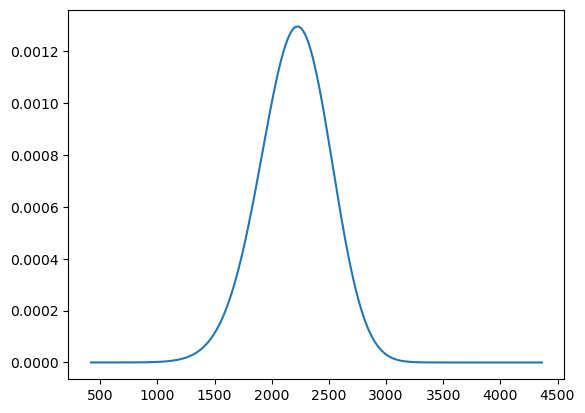

In [3]:

chi = ccl.comoving_radial_distance(cosmo,1/(1+z))
kmin, kmax, nk = 1e-4, 1e1, 500
k = np.geomspace((kmin), (kmax), nk) # Wavenumber
pk_nl = []
for zet in z:
    pk_nl.append(ccl.nonlin_matter_power(cosmo, k, 1/(1+zet)))
pk_nl = np.array(pk_nl)


spl = UnivariateSpline(chi, z, k=2, s=0)
dzdchi = spl.derivative()(chi)
norm = 1/np.trapz(nz*dzdchi,chi)
nofchi = dzdchi*nz*norm
idx_non_zero = np.where(nofchi >0)[0]
print(len(idx_non_zero))

plt.plot(chi,nofchi)

print(chi[idx_non_zero[-1]] - chi[idx_non_zero[0]])

mean_chi = np.argmin(np.abs(chi - np.trapz(nz*dzdchi*norm*chi,chi)))
print(np.trapz(nz*dzdchi*norm*chi,chi)/np.sqrt(np.trapz(nz*dzdchi*norm*chi**2,chi) - np.trapz(nz*dzdchi*norm*chi,chi)**2)) 


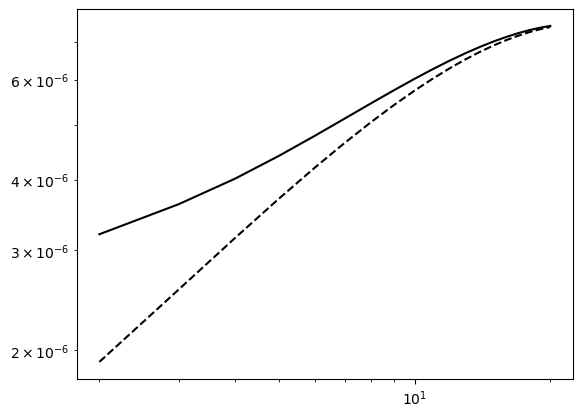

In [4]:
cls = ccl.angular_cl(cosmo, tracers['g'], tracers['g'], ell, l_limber = 10009,limber_max_error=0.0001) 
cls1 = ccl.angular_cl(cosmo, tracers['g'], tracers['g'], ell, l_limber = 1,limber_max_error=0.0001)

plt.loglog(ell, cls, 'k-')
plt.loglog(ell, cls1, 'k--')

In [23]:
'''
integral_type = 2
N_thread = 8 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
n_sub = 8 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?

lower_limit = k[0]*np.ones_like(ell)
upper_limit = np.ones_like(ell)

integrand = (pk_nl[mean_chi,:]*k**2)[:,None]

result_levin = np.zeros((len(idx_non_zero), len(idx_non_zero), len(ell)))
for i_chi, val_i_chi in enumerate(chi[idx_non_zero]):
    for j_chi, val_j_chi in enumerate(chi[idx_non_zero]):
        print(i_chi,j_chi)
        spline = UnivariateSpline(k, pk_nl[idx_non_zero[i_chi],:], k= 3, s = 0)
        power = spline(k)**.5
        spline = UnivariateSpline(k, pk_nl[idx_non_zero[j_chi],:], k= 3, s = 0)
        power *= spline(k)**.5
        integrand = power*k**2
        if i_chi <= j_chi:
            lp = levinpower.levinpower(integral_type, k, integrand[:,None], logx, logy, N_thread)
            lp.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)
            result_levin[i_chi,j_chi,:] = (np.array(lp.levin_integrate_bessel_double(lower_limit, upper_limit, val_j_chi*np.ones_like(ell),val_i_chi*np.ones_like(ell),ell.astype(int),ell.astype(int), False))[:,0])
print(result_levin.shape)

for i in range(len(idx_non_zero)):
    for j in range(i,len(idx_non_zero)):
        result_levin[j,i,:] = result_levin[i,j,:]

result_levin_first = np.trapz(result_levin*(nofchi[idx_non_zero])[None, :, None] , chi[idx_non_zero],axis = 1)
result_levin_second = np.trapz((nofchi[idx_non_zero])[:, None]*result_levin_first , chi[idx_non_zero],axis = 0)


'''
integral_type = 0
N_thread = 8 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
n_sub = 8 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-6 #relative accuracy target
boost_bessel = False #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?

lower_limit = k[0]*np.ones_like(ell)
upper_limit = np.ones_like(ell)

N_int = int(1e3)
k_int = np.geomspace(k[0], 1e-1, N_int)

inner_int = np.zeros((len(ell), len(k_int)))
pk_nl_new = np.zeros((len(z), len(k_int)))
for zet_i, zet_val in enumerate(z):
    pk_nl_new[zet_i,:] = (ccl.nonlin_matter_power(cosmo, k_int, 1/(1+zet_i)))

'''for i_ell, val_ell in enumerate(ell):
    print(i_ell, val_ell)
    lp = levinpower.levinpower(integral_type, chi, np.sqrt(pk_nl_new)*nofchi[:,None], logx, logy, N_thread)
    lp.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)
    lower_limit = chi[0]*np.ones_like(k_int)
    upper_limit = chi[-1]*np.ones_like(k_int)
    ell_values = (val_ell*np.ones_like(k_int)).astype(int)
    inner_int[i_ell,:] = np.diag(np.array(lp.levin_integrate_bessel_single(lower_limit, upper_limit, k_int, ell_values, True)))
'''

for i_ell, val_ell in enumerate(ell):
    lp = levinpower.levinpower(integral_type, chi, np.sqrt(pk_nl_new[:,i_k])*nofchi[:,None], logx, logy, N_thread)
    lp.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)
    lower_limit = chi[0]*np.ones_like(k_int)
    upper_limit = chi[-1]*np.ones_like(k_int)
    ell_values = (val_ell*np.ones_like(k_int)).astype(int)
    inner_int[i_ell,:] = np.diag(np.array(lp.levin_integrate_bessel_single(lower_limit, upper_limit, k_int, ell_values, True)))


result_levin_second = 2/np.pi*np.trapz(inner_int**2*k_int**2,k_int, axis = -1)

1.0
0 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9
8 10
9 11
10 12
11 13
12 14
13 15
14 16
15 17
16 18
17 19
18 20


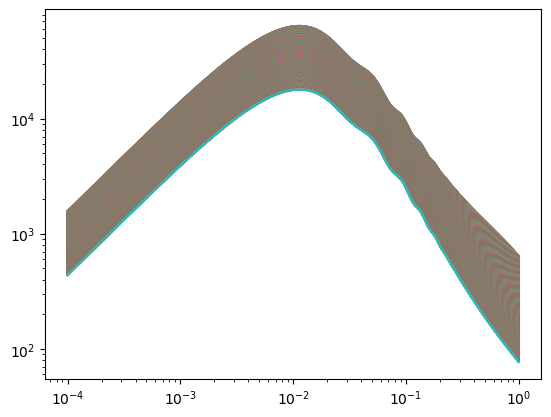

In [10]:
from scipy.special import spherical_jn



N_int = int(1e3)
k_int = np.geomspace(k[0], 1, N_int)
bessel = []
spline = UnivariateSpline(k, pk_nl[mean_chi,:], k= 3, s = 0) # assume power spectrum is constant over bin
for i_chi, val_chi in enumerate(chi[idx_non_zero]):
    bessel.append([])
    power = ccl.nonlin_matter_power(cosmo,k_int,1./(1+z[idx_non_zero[i_chi]]))#spline(k_int)**.5    
    for ell_i, ell_val in enumerate(ell):
        bessel[i_chi].append(spherical_jn(ell_val,val_chi*k_int)*np.sqrt(power))
    #plt.loglog(k_int, power)

bessel = np.array(bessel)
integral_1 = np.trapz(nofchi[idx_non_zero,None, None]*bessel,chi[idx_non_zero], axis=0)


result = 2/np.pi*np.trapz(integral_1**2*k_int**2,k_int, axis = -1)

In [11]:
integ_1 = np.trapz(bessel*(nofchi[idx_non_zero])[:,None, None],chi[idx_non_zero], axis = 0)

result_new = 2/np.pi*np.trapz((integ_1*k_int[None,:])**2,k_int,axis = -1)

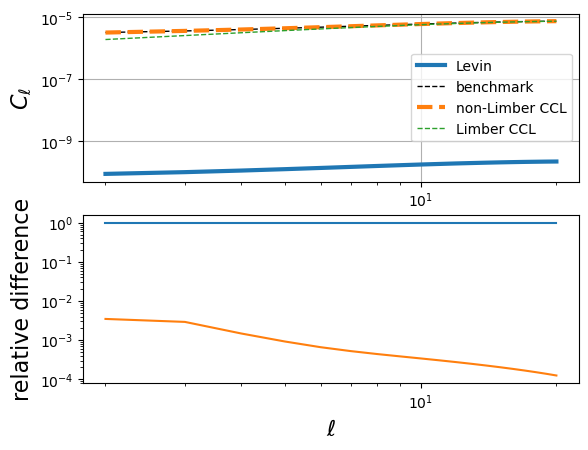

In [12]:
fig, ax = plt.subplots(2)


my_limber = np.trapz((nofchi**2)[None,:]/chi**2*spline((ell+.5)/chi[mean_chi])[:,None],chi)

#plt.loglog(ell,result_levin, ls = "-")
ax[0].loglog(ell,result_levin_second, ls = "-", label = r"Levin", lw = 3)
ax[0].loglog(ell,result_new, ls = "--", label = r"benchmark", lw= 1, color = "black")

ax[0].loglog(ell,cls, ls = "--", label = r"non-Limber CCL", lw = 3)
ax[0].loglog(ell,cls1, ls = "--", label = r"Limber CCL", lw = 1)
ax[0].grid(axis = "both")

ax[1].loglog(ell, np.abs(result_levin_second*2/np.pi - result_new)/result_new)
ax[1].loglog(ell, np.abs(cls - result_new)/result_new)
ax[1].set_xlabel(r"$\ell$", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
#ax[1].set_ylim(-1e-4,1e-4)


ax[1].set_xlabel(r"$\ell$", fontsize = 16)
ax[0].set_ylabel(r"$C_\ell$", fontsize = 16)
ax[0].legend()
